# Model creation

In this notebook the pre-processed data is used for model generation, deployment and prediction making. Two algorithms, the Linear Learner & the XGBoost are evaluated against a simple benchmark model. The experiments are conducted using both the original and reduced (by PCA) datasets.

## Load data

In [1]:
import pandas as pd
import numpy as np
import sagemaker
import boto3
import math
import os
from sagemaker.amazon.amazon_estimator import RecordSet, get_image_uri
from sagemaker.predictor import csv_serializer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

In [2]:
input_file_path = 'data/data_ready.csv'
data_ready = pd.read_csv(input_file_path)

input_file_path_pca = 'data/data_ready_pca.csv'
data_ready_pca = pd.read_csv(input_file_path_pca)

## Split data

Due to the low amount of data it was decided to keep only 10% of the data for validation or test purposes.

In [3]:
test_size = 0.1
random_state = 11

In [4]:
def split_data(dataframe, test_size, random_state):

    dftr = dataframe.drop(labels=['NetSalary'], axis=1).astype(np.float32)
    dfts = dataframe['NetSalary'].astype(np.float32)

    return train_test_split(dftr, dfts, test_size=test_size, random_state=random_state)

## Evaluation metrics

For the evaluation of the generated models the following metrics were selected:
- Mean absolute error
- Median absolute error
- Root mean square error

Apart from the metrics, a histogram plot is generated that depicts the original values of the test data, the predicted values & their difference.

In [5]:
def evaluate_metrics(y_true, y_pred):

    r = pd.DataFrame(data={'original':y_true,'predictions':y_pred})
    r['difference'] = r['predictions'] - r['original']
    r.plot.hist(figsize=(15,10),bins=100,alpha=0.5)
    
    mean_absolute_error_metric = mean_absolute_error(y_true, y_pred)
    median_absolute_error_metric = median_absolute_error(y_true, y_pred)
    root_mean_square_error_metric = math.sqrt(mean_squared_error(y_true, y_pred))

    print('Mean absolute error:', mean_absolute_error_metric)
    print('Median absolute error:', median_absolute_error_metric)
    print('Root mean square error:', root_mean_square_error_metric)
    
    return (mean_absolute_error_metric, median_absolute_error_metric, root_mean_square_error_metric)

## LinearLearner model

The first algorithm to be used is the Linear Learner. The helper function below trains an estimator, deploys the model and generates predictions for the test data. In the end, the deployed endpoint is deleted.

In [6]:
def get_linear_learner_predictions(train_features, test_features, train_labels, test_labels):
    
    # instantiate the LinearLearner estimator object
    linear_learner_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                                   train_instance_count=1,
                                                   train_instance_type='ml.m4.xlarge',
                                                   predictor_type='regressor',epochs=80)
    
    # wrap data in RecordSet objects
    train_records = linear_learner_estimator.record_set(train_features.to_numpy(), train_labels.to_numpy(), channel='train')
    val_records = linear_learner_estimator.record_set(test_features.to_numpy(), test_labels.to_numpy(), channel='validation')
    test_records = linear_learner_estimator.record_set(test_features.to_numpy(), test_labels.to_numpy(), channel='test')
    
    # start a training job
    linear_learner_estimator.fit([train_records, test_records])
    
    # deploy a model hosting endpoint
    linear_learner_predictor = linear_learner_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
    
    results = linear_learner_predictor.predict(test_features.to_numpy())
    
    extract_results = lambda x: x.label['score'].float32_tensor.values[0]

    predictions = list(map(extract_results, results))
    
    # delete endpoint
    linear_learner_predictor.delete_endpoint()
    
    return predictions

## Xgboost model

The second algorithm to be used is the XGBoost. The helper functions below assist in training an estimator, deploying the model and the generation of predictions for the test data. In the end, the deployed endpoint is deleted.

In [7]:
def predict(data, predictor, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [8]:
def get_xgboost_predictions(train_features, test_features, train_labels, test_labels):

    train_features.insert(loc=0,column='target',value=train_labels)
    test_features.insert(loc=0,column='target',value=test_labels)

    train_features.to_csv('data_stam/train.csv', header=False, index=False)
    test_features.to_csv('data_stam/test.csv', header=False, index=False)

    session = sagemaker.Session()
    bucket = session.default_bucket()
    prefix = 'udacity-nd009t-capstone-project'

    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('data_stam/train.csv')
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('data_stam/test.csv')

    s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
    s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

    hyperparameters = {
        'objective': 'reg:squarederror',
        'num_round': 50
    }

    # this line automatically looks for the XGBoost image URI and builds an XGBoost container.
    # specify the repo_version depending on your preference.
    xgboost_container = get_image_uri(boto3.Session().region_name,
                              'xgboost', 
                              repo_version='1.0-1')

    # construct a SageMaker estimator that calls the xgboost-container
    xgboost_estimator = sagemaker.estimator.Estimator(image_name=xgboost_container, 
                                              hyperparameters=hyperparameters,
                                              role=sagemaker.get_execution_role(),
                                              train_instance_count=1, 
                                              train_instance_type='ml.m4.xlarge')

    xgboost_estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})
    
    # deploy a model hosting endpoint
    xgboost_predictor = xgboost_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

    xgboost_predictor.content_type = 'text/csv'
    xgboost_predictor.serializer = csv_serializer
    xgboost_predictor.deserializer = None

    predictions = predict(test_features.to_numpy()[:, 1:], xgboost_predictor)
    
    # delete endpoint
    xgboost_predictor.delete_endpoint()
    
    return predictions

## Experiments

The data is splitted to the necessary parts.

In [9]:
train_features, test_features, train_labels, test_labels = split_data(data_ready, test_size, random_state)

### Benchmark model

A simple benchmark model is defined so the generated models can be evaluated against it. The simple model simply predicts each test case as the median of the training data set `NetSalary` values.

Mean absolute error: 7054.6082974137935
Median absolute error: 4700.0
Root mean square error: 10289.063487289963


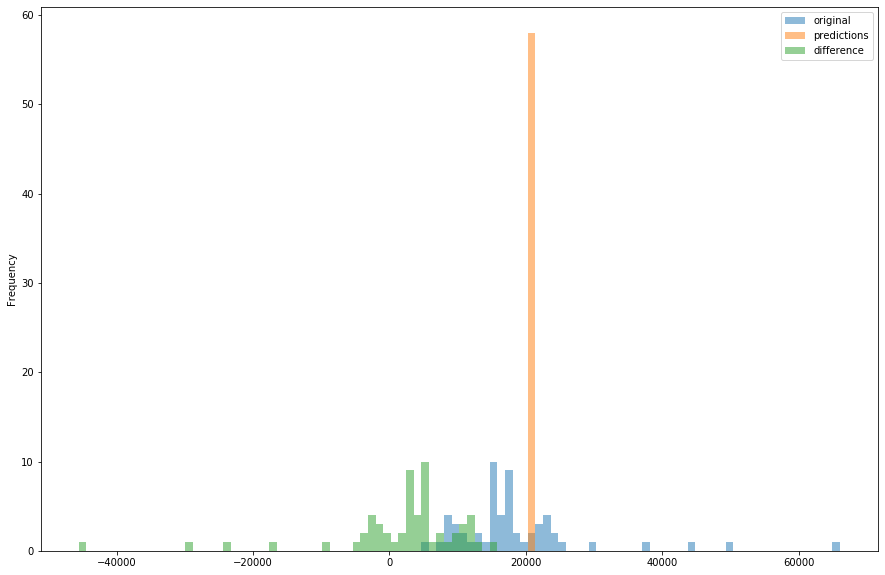

In [10]:
benchmark_predictions = np.full(shape=test_labels.size,fill_value=train_labels.mean())
benchmark_predictions_metrics = evaluate_metrics(test_labels, benchmark_predictions)

Predictions are generated for the two algorithms described above & the evaluation metrics are calculated.

In [11]:
ll_predictions = get_linear_learner_predictions(train_features.copy(), test_features.copy(), train_labels.copy(), test_labels.copy())

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-29 16:29:57 Starting - Starting the training job...
2020-10-29 16:30:00 Starting - Launching requested ML instances.........
2020-10-29 16:31:33 Starting - Preparing the instances for training...
2020-10-29 16:32:28 Downloading - Downloading input data......
2020-10-29 16:33:29 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/29/2020 16:33:32 INFO 140542095263552] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'in


2020-10-29 16:33:47 Uploading - Uploading generated training model
2020-10-29 16:33:47 Completed - Training job completed


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Training seconds: 79
Billable seconds: 79
---------------!

In [12]:
xgb_predictions = get_xgboost_predictions(train_features.copy(), test_features.copy(), train_labels.copy(), test_labels.copy())

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-29 16:41:49 Starting - Starting the training job...
2020-10-29 16:41:52 Starting - Launching requested ML instances......
2020-10-29 16:43:06 Starting - Preparing the instances for training...
2020-10-29 16:43:50 Downloading - Downloading input data...
2020-10-29 16:44:15 Training - Downloading the training image.....INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[16:44:57] 521x112 matrix with 58352 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Training seconds: 77
Billable seconds: 77
-----------------!

Mean absolute error: 4919.766130118534
Median absolute error: 3445.22607421875
Root mean square error: 8751.813913601869


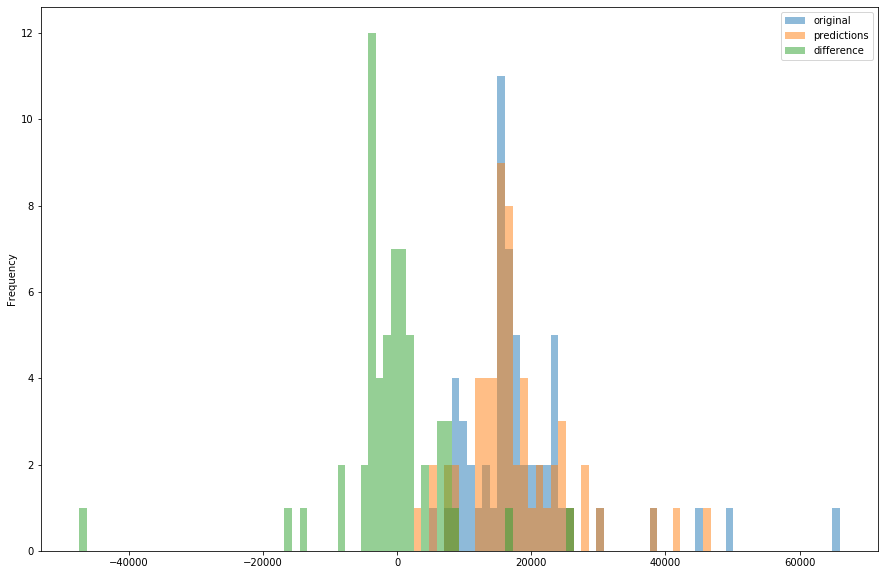

In [13]:
ll_predictions_metrics = evaluate_metrics(test_labels, ll_predictions)

Mean absolute error: 3629.9405138739226
Median absolute error: 1509.6572265625
Root mean square error: 7509.408630525133


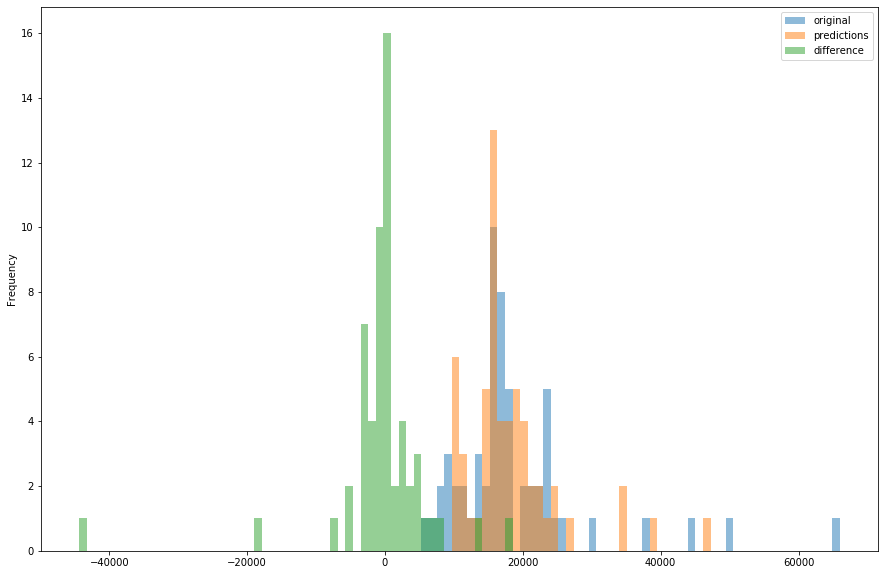

In [14]:
xgb_predictions_metrics = evaluate_metrics(test_labels, xgb_predictions)

The whole process is repeated for the reduced PCA data.

In [15]:
train_features, test_features, train_labels, test_labels = split_data(data_ready_pca, test_size, random_state)

In [16]:
ll_pca_predictions = get_linear_learner_predictions(train_features.copy(), test_features.copy(), train_labels.copy(), test_labels.copy())

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-29 16:54:09 Starting - Starting the training job...
2020-10-29 16:54:12 Starting - Launching requested ML instances......
2020-10-29 16:55:23 Starting - Preparing the instances for training.........
2020-10-29 16:56:49 Downloading - Downloading input data...
2020-10-29 16:57:30 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/29/2020 16:57:54 INFO 140444271798080] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u


2020-10-29 16:58:07 Uploading - Uploading generated training model
2020-10-29 16:58:07 Completed - Training job completed


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Training seconds: 78
Billable seconds: 78
-------------------!

In [17]:
xgb_pca_predictions = get_xgboost_predictions(train_features.copy(), test_features.copy(), train_labels.copy(), test_labels.copy())

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-29 17:08:03 Starting - Starting the training job...
2020-10-29 17:08:06 Starting - Launching requested ML instances.........
2020-10-29 17:09:36 Starting - Preparing the instances for training......
2020-10-29 17:10:51 Downloading - Downloading input data...
2020-10-29 17:11:22 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:11:45] 521x18 matrix with 9378 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter o

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Training seconds: 64
Billable seconds: 64
-----------------!

Mean absolute error: 5196.770575161638
Median absolute error: 3192.43505859375
Root mean square error: 8456.198673018509


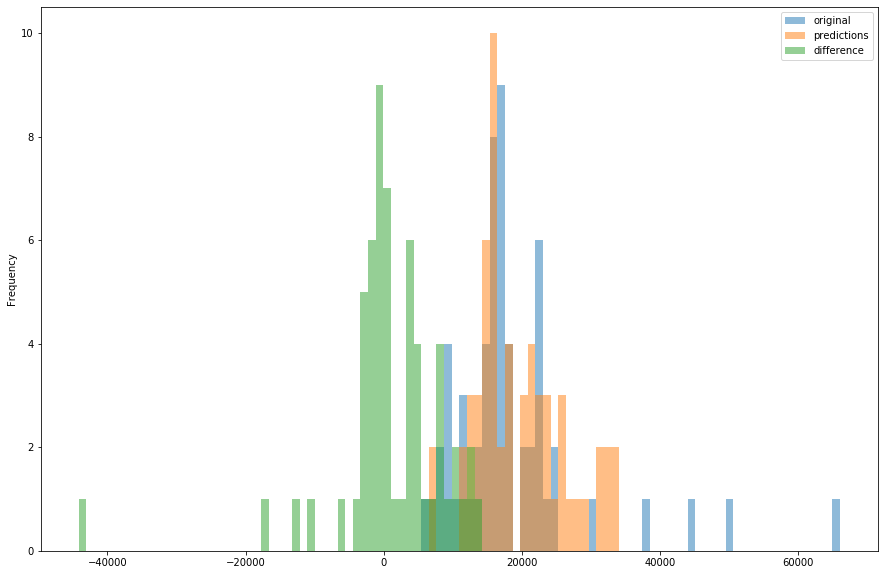

In [18]:
ll_pca_predictions_metrics = evaluate_metrics(test_labels, ll_pca_predictions)

Mean absolute error: 5152.735317887931
Median absolute error: 2255.6904296875
Root mean square error: 8864.641505589048


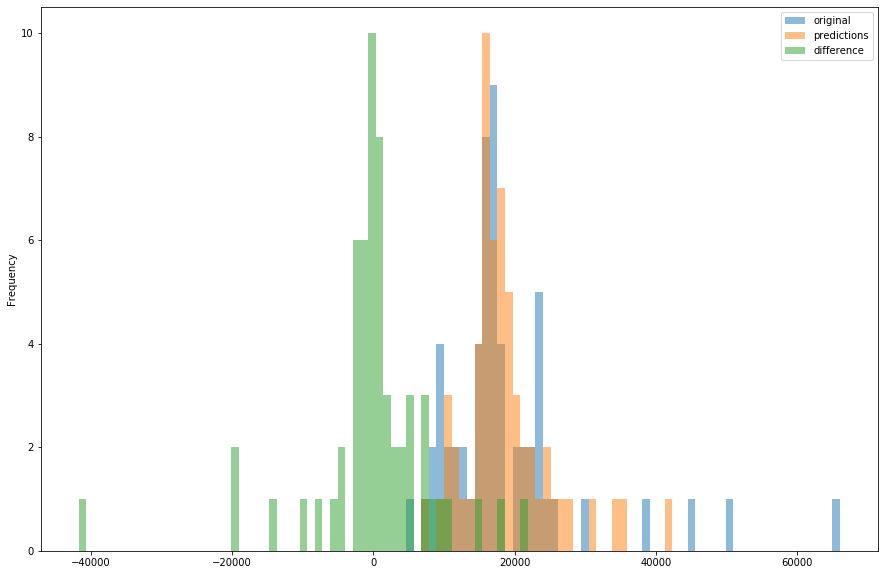

In [19]:
xgb_pca_predictions_metrics = evaluate_metrics(test_labels, xgb_pca_predictions)